# 1) 데이터 준비와 전처리

In [486]:
import os
import pandas as pd

rating_file_path = os.getenv('HOME')+'/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding='ISO-8859-1')
original_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [487]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'original_data_size : {original_data_size}, filtered_data_size : {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size : .2%}')

original_data_size : 1000209, filtered_data_size : 836478
Ratio of Remaining Data is  83.63%


In [488]:
# rating 컬럼의 이름을 count로 바꾸자
ratings.rename(columns={'rating' : 'counts'}, inplace=True)

In [489]:
ratings['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

In [490]:
# timestamp 컬럼 제거
ratings.drop(['timestamp'], axis=1, inplace=True)

In [491]:
# 영화 제목을 보기 위해 메타 데이터를 읽어오자.
movie_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [492]:
merge_df = pd.merge(ratings,movies, how='left', left_on='movie_id', right_on='movie_id')   #열방향(axis=1), 교집합(inner)
print(merge_df)

        user_id  movie_id  counts                                   title  \
0             1      1193       5  One Flew Over the Cuckoo's Nest (1975)   
1             1       661       3        James and the Giant Peach (1996)   
2             1       914       3                     My Fair Lady (1964)   
3             1      3408       4                  Erin Brockovich (2000)   
4             1      2355       5                    Bug's Life, A (1998)   
...         ...       ...     ...                                     ...   
836473     6040      1090       3                          Platoon (1986)   
836474     6040      1094       5                 Crying Game, The (1992)   
836475     6040       562       5         Welcome to the Dollhouse (1995)   
836476     6040      1096       4                  Sophie's Choice (1982)   
836477     6040      1097       4       E.T. the Extra-Terrestrial (1982)   

                                  genre  
0                                

In [493]:
merge_df = merge_df[['user_id', 'title', 'counts']]
display(merge_df.head(20))

,user_id,title,counts
0,1,One Flew Over the Cuckoo's Nest (1975),5
1,1,James and the Giant Peach (1996),3
2,1,My Fair Lady (1964),3
3,1,Erin Brockovich (2000),4
4,1,"Bug's Life, A (1998)",5
5,1,"Princess Bride, The (1987)",3
6,1,Ben-Hur (1959),5
7,1,"Christmas Story, A (1983)",5
8,1,Snow White and the Seven Dwarfs (1937),4
9,1,"Wizard of Oz, The (1939)",4


## 1-2)사용자의 명시적/암묵적 평가

In [494]:
# 별점 4개면 해당 영화를 이상이면 좋아한다고 판단한다.
nolike_movie = merge_df[merge_df['counts']<4]
nolike, all_data = len(nolike_movie), len(merge_df)
print(f'{nolike}, {all_data}')
print(f'Ratio of nolike over all data is {nolike/all_data:.2%}')

261197, 836478
Ratio of nolike over all data is 31.23%


In [495]:
# def movieid_to_title(id):
#     temp = merge_df.loc[(merge_df['movie_id'] == id)]['title']
#     temp = temp.reset_index()
#     return temp.iloc[0]['title']
    
# movieid_to_title(1193)

여기까지가 전처리입니다.         
이후에는 이전 스텝에 소개했던 것과 동일한 방식으로 MF model을 구성하여 내가 좋아할 만한 영화를 추천해 볼 수 있습니다.

# 2) 분석해보자

* ratings에 있는 유니크한 영화 개수
* rating에 있는 유니크한 사용자 수
* 가장 인기 있는 영화 30개(인기순)

In [496]:
merge_df['title'].nunique()

3628

In [497]:
merge_df['user_id'].nunique()

6039

In [498]:
# 인기 많은 영화 숫자
merge_count = merge_df.groupby('title')['user_id'].count()
merge_count.sort_values(ascending=False).head(30)

title
American Beauty (1999)                                   3211
Star Wars: Episode IV - A New Hope (1977)                2910
Star Wars: Episode V - The Empire Strikes Back (1980)    2885
Star Wars: Episode VI - Return of the Jedi (1983)        2716
Saving Private Ryan (1998)                               2561
Terminator 2: Judgment Day (1991)                        2509
Silence of the Lambs, The (1991)                         2498
Raiders of the Lost Ark (1981)                           2473
Back to the Future (1985)                                2460
Matrix, The (1999)                                       2434
Jurassic Park (1993)                                     2413
Sixth Sense, The (1999)                                  2385
Fargo (1996)                                             2371
Braveheart (1995)                                        2314
Men in Black (1997)                                      2297
Schindler's List (1993)                                  2257
Pr

# 3) 내가 선호하는 영화를 5가지 골라서 ratings에 추가해보자

In [499]:
merge_df.tail(20)

,user_id,title,counts
836458,6040,Schindler's List (1993),5
836459,6040,Short Cuts (1993),4
836460,6040,Metropolis (1926),5
836461,6040,Back to the Future Part II (1989),4
836462,6040,Chicken Run (2000),4
836463,6040,Seven Samurai (The Magnificent Seven) (Shichin...,5
836464,6040,Blade Runner (1982),4
836465,6040,Sleeper (1973),5
836466,6040,Thirty-Two Short Films About Glenn Gould (1993),4
836467,6040,Dangerous Liaisons (1988),3


In [500]:
merge_df['user_id']

0            1
1            1
2            1
3            1
4            1
          ... 
836473    6040
836474    6040
836475    6040
836476    6040
836477    6040
Name: user_id, Length: 836478, dtype: int64

In [501]:
my_favorite = ['Terminator 2: Judgment Day (1991)', 'Matrix, The (1999)', 'Sixth Sense, The (1999)', 'Godfather, The (1972)', 'American Beauty (1999)']

# 'zimin' 이라는 user_id가 위 아티스트의 노래를 30회씩 들었다고 가정하자.
my_watchlist = pd.DataFrame({'user_id':[9999]*5, 'title':my_favorite, 'counts':[5]*5}) # 내아이디 : 9999

if not merge_df.isin({'user_id':[9999]})['user_id'].any(): # user_id에 '9999'이라는 데이타거 없다면
    merge_df = merge_df.append(my_watchlist) # 위에 임으로 만든 my_favorite 데이터를 추가해준다.

#merge_df.reset_index(drop=True, inplace=True)
merge_df.tail(10)

,user_id,title,counts
836473,6040,Platoon (1986),3
836474,6040,"Crying Game, The (1992)",5
836475,6040,Welcome to the Dollhouse (1995),5
836476,6040,Sophie's Choice (1982),4
836477,6040,E.T. the Extra-Terrestrial (1982),4
0,9999,Terminator 2: Judgment Day (1991),5
1,9999,"Matrix, The (1999)",5
2,9999,"Sixth Sense, The (1999)",5
3,9999,"Godfather, The (1972)",5
4,9999,American Beauty (1999),5


# 4) CSR matrix를 직접 만들어 보자

In [502]:
csr_df = merge_df.copy()

user_unique = csr_df['user_id'].unique()
title_unique = csr_df['title'].unique()

print(len(user_unique), len(title_unique))
# 유저, 무비 indexing 하는 코드 idx는 index의 약자이다.
user_to_idx = {v:k for k,v in enumerate(user_unique)}
title_to_idx = {v:k for k,v in enumerate(title_unique)}

display(user_to_idx)
display(title_to_idx)

6040 3628


{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16,
 18: 17,
 19: 18,
 20: 19,
 21: 20,
 22: 21,
 23: 22,
 24: 23,
 25: 24,
 26: 25,
 27: 26,
 28: 27,
 29: 28,
 30: 29,
 31: 30,
 32: 31,
 33: 32,
 34: 33,
 35: 34,
 36: 35,
 37: 36,
 38: 37,
 39: 38,
 40: 39,
 41: 40,
 42: 41,
 43: 42,
 44: 43,
 45: 44,
 46: 45,
 47: 46,
 48: 47,
 49: 48,
 50: 49,
 51: 50,
 52: 51,
 53: 52,
 54: 53,
 55: 54,
 56: 55,
 57: 56,
 58: 57,
 59: 58,
 60: 59,
 61: 60,
 62: 61,
 63: 62,
 64: 63,
 65: 64,
 66: 65,
 67: 66,
 68: 67,
 69: 68,
 70: 69,
 71: 70,
 72: 71,
 73: 72,
 74: 73,
 75: 74,
 76: 75,
 77: 76,
 78: 77,
 79: 78,
 80: 79,
 81: 80,
 82: 81,
 83: 82,
 84: 83,
 85: 84,
 86: 85,
 87: 86,
 88: 87,
 89: 88,
 90: 89,
 91: 90,
 92: 91,
 93: 92,
 94: 93,
 95: 94,
 96: 95,
 97: 96,
 98: 97,
 99: 98,
 100: 99,
 101: 100,
 102: 101,
 103: 102,
 104: 103,
 105: 104,
 106: 105,
 107: 106,
 108: 107,
 109: 108,
 110: 109,
 111: 11

{"One Flew Over the Cuckoo's Nest (1975)": 0,
 'James and the Giant Peach (1996)': 1,
 'My Fair Lady (1964)': 2,
 'Erin Brockovich (2000)': 3,
 "Bug's Life, A (1998)": 4,
 'Princess Bride, The (1987)': 5,
 'Ben-Hur (1959)': 6,
 'Christmas Story, A (1983)': 7,
 'Snow White and the Seven Dwarfs (1937)': 8,
 'Wizard of Oz, The (1939)': 9,
 'Beauty and the Beast (1991)': 10,
 'Gigi (1958)': 11,
 'Miracle on 34th Street (1947)': 12,
 "Ferris Bueller's Day Off (1986)": 13,
 'Sound of Music, The (1965)': 14,
 'Airplane! (1980)': 15,
 'Tarzan (1999)': 16,
 'Bambi (1942)': 17,
 'Awakenings (1990)': 18,
 'Big (1988)': 19,
 'Pleasantville (1998)': 20,
 'Wallace & Gromit: The Best of Aardman Animation (1996)': 21,
 'Back to the Future (1985)': 22,
 "Schindler's List (1993)": 23,
 'Meet Joe Black (1998)': 24,
 'Pocahontas (1995)': 25,
 'E.T. the Extra-Terrestrial (1982)': 26,
 'Titanic (1997)': 27,
 'Ponette (1996)': 28,
 'Close Shave, A (1995)': 29,
 'Antz (1998)': 30,
 'Girl, Interrupted (1999)':

In [503]:
# 인덱싱이 잘 되어 있는지 확인해보자.
print(user_to_idx[9999]) # 358869명의 유저 중 마지막으로 추가된 유저이니 358868이 나와야 한다.
print(title_to_idx['Maverick (1994)'])

6039
79


In [504]:
# indexing 을 통해 데이터 컬럼 내 값을 바꾸는 코드

# user_to_inx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해보자.
# 혹시 정상적으로 인덱싱 되지 않은 row가 있다면 인덱스가 Nan이 될테니 dropna()로 제거
temp_user_data = csr_df['user_id'].map(user_to_idx.get).dropna()
if len(temp_user_data) == len(csr_df): # 모든 row가 정상적으로 인덱싱 되었다면
    print('user_id column indexing OK!!')
    csr_df['user_id'] = temp_user_data # csr_df['user_id']를 인덱싱된 Series로 교체해준다.
else:
    print('user_id column indexing Fail!!')
    
# movie_to_idx를 통해 movie 컬럼도 동일한 방식으로 인덱싱 해준다.
temp_title_data = csr_df['title'].map(title_to_idx.get).dropna()
if len(temp_title_data) == len(csr_df):
    print('title column indexing OK!!!')
    csr_df['title'] = temp_title_data
else:
    print(len(temp_title_data), len(csr_df))
    print('title column indexing Fail!!!')
    
csr_df

user_id column indexing OK!!
title column indexing OK!!!


,user_id,title,counts
0,0,0,5
1,0,1,3
2,0,2,3
3,0,3,4
4,0,4,5
...,...,...,...
0,6039,92,5
1,6039,124,5
2,6039,38,5
3,6039,607,5


In [506]:
from scipy.sparse import csr_matrix

num_user = csr_df['user_id'].nunique()
num_title = csr_df['title'].nunique()

#csr_data = csr_matrix((data.play, (data.user_id, data.artist)), shape=(num_user, num_artist))
csr_data = csr_matrix((csr_df.counts, (csr_df.user_id, csr_df.title)), shape=(num_user, num_title))

print(csr_data)

  (0, 0)	5
  (0, 1)	3
  (0, 2)	3
  (0, 3)	4
  (0, 4)	5
  (0, 5)	3
  (0, 6)	5
  (0, 7)	5
  (0, 8)	4
  (0, 9)	4
  (0, 10)	5
  (0, 11)	4
  (0, 12)	4
  (0, 13)	4
  (0, 14)	5
  (0, 15)	4
  (0, 16)	3
  (0, 17)	4
  (0, 18)	5
  (0, 19)	4
  (0, 20)	3
  (0, 21)	3
  (0, 22)	5
  (0, 23)	5
  (0, 24)	3
  :	:
  (6038, 2311)	4
  (6038, 2317)	5
  (6038, 2386)	4
  (6038, 2394)	5
  (6038, 2424)	4
  (6038, 2437)	4
  (6038, 2446)	5
  (6038, 2471)	4
  (6038, 2511)	5
  (6038, 2523)	4
  (6038, 2559)	3
  (6038, 2560)	4
  (6038, 2631)	5
  (6038, 2648)	4
  (6038, 2654)	5
  (6038, 2738)	4
  (6038, 2740)	5
  (6038, 2857)	5
  (6038, 2860)	3
  (6038, 3311)	5
  (6039, 38)	5
  (6039, 92)	5
  (6039, 99)	5
  (6039, 124)	5
  (6039, 607)	5


# 5) als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련시켜보자

In [536]:
from implicit.als import AlternatingLeastSquares
import numpy as np
# Implicit AlternatingLeastSquares 모델 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=30, dtype=np.float32)

In [537]:
# als 모델은 input으로(item x user 꼴의 matrix를 받기 때문에 Transpose 해주자.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.longlong'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [538]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/30 [00:00<?, ?it/s]

# 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해보자

In [539]:
namjisu, matrix = user_to_idx[9999], title_to_idx['Matrix, The (1999)']
namjisu_vector, matrix_vector = als_model.user_factors[namjisu], als_model.item_factors[matrix]

print('슝=3')

슝=3


In [540]:
namjisu_vector

array([ 0.03514272,  0.09502171,  0.40557703,  0.15998279,  0.07100654,
       -0.14423993, -0.28560677, -0.47261164,  0.43175304, -0.26032725,
        0.64613676, -0.36027378, -1.23144   , -0.20290765,  0.33446825,
        0.33733308, -0.12596904,  0.27454144, -0.15775597, -0.28251967,
       -0.438621  , -0.5205847 ,  0.3947223 ,  0.14639266, -0.3182781 ,
       -0.8604974 ,  0.33812279,  0.31954733,  1.0307341 ,  1.1823032 ,
       -1.0040362 , -0.3603785 , -0.44010946,  0.6690236 ,  0.63284683,
        0.10817709, -0.24146846,  0.81339616,  0.1072652 ,  0.29436913,
        0.41301423,  0.392742  ,  0.00836849,  0.09425157, -0.36238942,
       -0.28722736, -0.22007793, -0.20387097, -0.54140157,  0.30383265,
       -0.39483374, -0.51487297, -0.8945502 ,  0.3360912 ,  0.0992228 ,
        0.5525216 , -0.4418649 , -0.10442688,  0.14419219, -0.06668315,
        0.37681448, -0.11838025, -0.48327708,  0.32874855, -0.23089564,
       -0.77581656, -0.34472805, -0.13293643, -0.4113917 ,  0.09

In [541]:
matrix_vector

array([ 0.02059529,  0.00774853,  0.00020355,  0.0410016 ,  0.00695134,
       -0.02875935, -0.00707799, -0.01008995,  0.01073728, -0.02233823,
        0.00799884, -0.01449109, -0.01756751,  0.0053597 , -0.0080114 ,
        0.03195772, -0.00497059, -0.00571542, -0.00024068, -0.00046418,
       -0.01439104, -0.02778263,  0.00465483,  0.02804223,  0.00727158,
        0.00187625,  0.00900142,  0.02659972,  0.04563935,  0.03932413,
        0.00784279, -0.02151072, -0.00408385,  0.05823814,  0.03684866,
        0.01131778,  0.0084639 ,  0.03438111,  0.02068465,  0.03572644,
        0.02411852,  0.00368809,  0.02679543, -0.0219653 , -0.02299813,
        0.01950154, -0.01324709, -0.01354278, -0.02167651, -0.00376686,
       -0.01500505, -0.01084029, -0.02485128,  0.01886379,  0.00391044,
        0.0175345 ,  0.00221835,  0.00497086,  0.02627212, -0.01687752,
        0.01429689,  0.01334271, -0.02248706,  0.02943891,  0.01943912,
       -0.03899547, -0.01807756,  0.01686727, -0.01758511,  0.01

In [542]:
# zimin과 black_eyed_peas 를 내적하는 코드
np.dot(namjisu_vector, matrix_vector)

0.5884942

In [543]:
diary = title_to_idx['Dear Diary (Caro Diario) (1994)']
diary_vector = als_model.item_factors[diary]
np.dot(namjisu_vector, diary_vector)

-0.0024421422

# 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 보자

In [544]:
favorite_movie = 'Matrix, The (1999)'
title_id = title_to_idx[favorite_movie]
similar_movie = als_model.similar_items(title_id, N=15)
similar_movie # (영화의 id, 유사도) 튜플로 반환

[(124, 1.0000001),
 (92, 0.76845235),
 (62, 0.66478336),
 (200, 0.5603307),
 (145, 0.54874337),
 (141, 0.5460491),
 (107, 0.506465),
 (375, 0.49358568),
 (175, 0.4697848),
 (317, 0.4331696),
 (75, 0.42477652),
 (44, 0.3834723),
 (431, 0.35812032),
 (193, 0.34857842),
 (117, 0.34835547)]

In [545]:
# title_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성한다.
idx_to_title = {v:k for k,v in title_to_idx.items()}
[idx_to_title[i[0]] for i in similar_movie]

['Matrix, The (1999)',
 'Terminator 2: Judgment Day (1991)',
 'Total Recall (1990)',
 'Terminator, The (1984)',
 'Fifth Element, The (1997)',
 'Fugitive, The (1993)',
 'Jurassic Park (1993)',
 'Face/Off (1997)',
 'Men in Black (1997)',
 'Twelve Monkeys (1995)',
 'Hunt for Red October, The (1990)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Gattaca (1997)',
 'Alien (1979)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)']

In [549]:
def get_similar_movie(movie_name: str):
    movie_id = title_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_title[i[0]] for i in similar_movie]
    return similar_movie

print("슝=3")

슝=3


In [550]:
get_similar_movie('Terminator 2: Judgment Day (1991)')

['Terminator 2: Judgment Day (1991)',
 'Matrix, The (1999)',
 'Total Recall (1990)',
 'Jurassic Park (1993)',
 'Men in Black (1997)',
 'Terminator, The (1984)',
 'Braveheart (1995)',
 'Fugitive, The (1993)',
 'Schlafes Bruder (Brother of Sleep) (1995)',
 'Hunt for Red October, The (1990)']

In [551]:
get_similar_movie('Dear Diary (Caro Diario) (1994)')

['Dear Diary (Caro Diario) (1994)',
 'Tigrero: A Film That Was Never Made (1994)',
 'Live Flesh (1997)',
 'My Son the Fanatic (1998)',
 'Contempt (Le Mépris) (1963)',
 'Careful (1992)',
 'I Stand Alone (Seul contre tous) (1998)',
 'Institute Benjamenta, or This Dream People Call Human Life (1995)',
 'Time Regained (Le Temps Retrouvé) (1999)',
 'Confessional, The (Le Confessionnal) (1995)']

# 8) 내가 가장 좋아할 만한 영화들을 추천 받아 보자

In [553]:
user = user_to_idx[9999]
# recommend에서는 user*item CSR Matrix를 받는다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(380, 0.5651005),
 (107, 0.47334647),
 (170, 0.42803627),
 (121, 0.3671834),
 (175, 0.35882646),
 (141, 0.3315522),
 (64, 0.3183697),
 (200, 0.31299156),
 (62, 0.3081494),
 (48, 0.28679413),
 (44, 0.2866721),
 (87, 0.28492063),
 (273, 0.27389467),
 (126, 0.2726736),
 (51, 0.2698012),
 (60, 0.25985327),
 (233, 0.2561534),
 (435, 0.24093121),
 (224, 0.240908),
 (22, 0.21968918)]

In [554]:
[idx_to_title[i[0]] for i in movie_recommended]

['Godfather: Part II, The (1974)',
 'Jurassic Park (1993)',
 'Being John Malkovich (1999)',
 'Silence of the Lambs, The (1991)',
 'Men in Black (1997)',
 'Fugitive, The (1993)',
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 'Terminator, The (1984)',
 'Total Recall (1990)',
 'Saving Private Ryan (1998)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Braveheart (1995)',
 'Fight Club (1999)',
 'Shakespeare in Love (1998)',
 'Fargo (1996)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Usual Suspects, The (1995)',
 'Godfather: Part III, The (1990)',
 'L.A. Confidential (1997)',
 'Back to the Future (1985)']

AlternatingLeastSquares 클래스에 구현된 explain 메소드를 사용하면 제가 기록을 남긴 데이터 중 이 추천에 기여한 정도를 확인할 수 있습니다.

In [555]:
ghost = title_to_idx['Ghost (1990)']
explain = als_model.explain(user, csr_data, itemid=ghost)

In [556]:
[(idx_to_title[i[0]], i[1]) for i in explain[1]]

[('Sixth Sense, The (1999)', 0.04470364608184145),
 ('Terminator 2: Judgment Day (1991)', 0.007482833187560628),
 ('Godfather, The (1972)', 0.001153349125114737),
 ('Matrix, The (1999)', -0.026330854888241825),
 ('American Beauty (1999)', -0.03592077819455043)]

# 9)루브릭

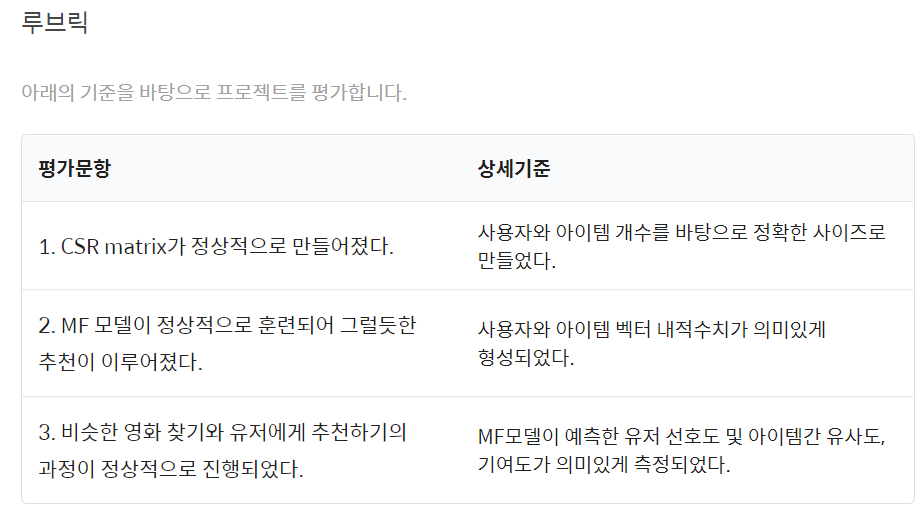

# 10) 회고

- 이번 프로젝트에서 **어려웠던 점,**        
    - CSR Matrix 구조에 대한 노드만으론 이해가 부족해서 블로그를 참조해 이해하였다.
CSR Matrix 의 행 수 에러가 지속적으로 발생해 원인을 찾아보다 기존 노드에서 했던 인덱싱을 하지 않아 발생한 오류란걸 깨닫고 처리하였다.   


- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.                          
    - AlternatingLeastSquares 모델에 대한 구조의 이해가 부족하다.


- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.               
    - 노드 참고 및 에러에 대한 원인 분석.


- **자기 다짐**           
    - 현재는 DataFrame에 movie title과 user id, counts 만을 사용하여 모델을 학습시켰지만, Genre를 통해 좀 더 정확성(?)이 높은 모델을 만들 수 있을 것 같다. 추후 시도해보도록 하자.